In [2]:
library(patchwork)
library(ggpubr)
library(monocle3)
library(Seurat)
library(harmony)
library(ggplot2)
library(dplyr)

In [ ]:
# Cell cycle analysis
# you can get cellcycle dataset from Seurat homepage
cellcycle <- function(cells) {
    # Read in the expression matrix The first row is a header row, the first column is rownames
    homedir = "/data/share/scRNAseq/results/human_STAD/cellranger_3.1/human_scRNAseq_analysis/pipeline"
    cc_file = paste0(homedir, "/working_data/cell_cycle/nestorawa_forcellcycle_expressionMatrix.txt")
    exp.mat <- read.table(file = cc_file, header = TRUE, 
        as.is = TRUE, row.names = 1)
    # A list of cell cycle markers, from Tirosh et al, 2015, is loaded with Seurat.  We can
    # segregate this list into markers of G2/M phase and markers of S phase
    s.genes <- cc.genes$s.genes
    g2m.genes <- cc.genes$g2m.genes
    cells <- CellCycleScoring(cells, 
                              s.features = s.genes, 
                              g2m.features = g2m.genes)
    return (cells)
}

### If you have done the CytoTRACE analysis, it is better to use it
### because you can decide a root cell easily with the rational reason.

In [14]:
seurat <- readRDS('./data_3_1_epi_cytotrace.rds')

In [15]:
colors <- readRDS('../distinct_colors.Rds')

In [ ]:
seurat <- cellcycle(seurat)

In [327]:
# get_annotation
gene_annotation <- as.data.frame(rownames(seurat@assays[["RNA"]]@counts), row.names = rownames(seurat@assays[["RNA"]]@counts))
colnames(gene_annotation) <- "gene_short_name"

### add the metadata
### You can add any metadata in Seurat object in the same way

In [328]:
# part two, cell information
# If you do not annotate the metadata such as cellcyle, omit it.
cell_metadata <- as.data.frame(seurat@assays[["RNA"]]@counts@Dimnames[[2]], row.names = seurat@assays[["RNA"]]@counts@Dimnames[[2]])
cell_metadata['celltype'] <- seurat@meta.data[['subcluster']]
cell_metadata['orig.ident'] <- seurat@meta.data[['orig.ident']]
cell_metadata['institution'] <- seurat@meta.data[['institution']]
cell_metadata['cellcyle'] <- seurat@meta.data[['Phase']]

In [28]:
colnames(cell_metadata) <- c("barcode",'celltype','orig.ident','institution','cellcycle')

In [29]:
# part three, counts sparse matrix
New_matrix <- seurat@assays[["RNA"]]@counts
New_matrix <- New_matrix[rownames(seurat@reductions[["harmony"]]@feature.loadings), ]
expression_matrix <- New_matrix

### Construct the basic cds object

In [332]:
cds_from_seurat <- new_cell_data_set(expression_matrix,
                                     cell_metadata = cell_metadata,
                                     gene_metadata = gene_annotation)

cds_from_seurat <- preprocess_cds(cds_from_seurat, num_dim = 8) # Jackstraw show PC=9 is not significant.
cds_from_seurat <- reduce_dimension(cds_from_seurat)

In [334]:
### Construct and assign the made up partition

recreate.partition <- c(rep(1, length(cds_from_seurat@colData@rownames)))
names(recreate.partition) <- cds_from_seurat@colData@rownames
recreate.partition <- as.factor(recreate.partition)

cds_from_seurat@clusters@listData[["UMAP"]][["partitions"]] <- recreate.partition


### Assign the cluster info

list_cluster <- seurat@meta.data[['subcluster']]
names(list_cluster) <- seurat@assays[["RNA"]]@data@Dimnames[[2]]
#list_cluster['institution'] <- seurat@meta.data[['institution']]

cds_from_seurat@clusters@listData[["UMAP"]][["clusters"]] <- list_cluster
#cds_from_seurat@clusters@listData[["UMAP"]][["institution"]] <- list_cluster[['institution']]



### Could be a space-holder, but essentially fills out louvain parameters

cds_from_seurat@clusters@listData[["UMAP"]][["louvain_res"]] <- "NA"


### Assign UMAP coordinate
## If you want to use seurat umap coordinates, you should do the code below,
## but I think monocle3 umap is better to see the trajectory.
#cds_from_seurat@reducedDims@listData[["UMAP"]] <-seurat@reductions[["umap"]]@cell.embeddings
#cds_from_seurat@int_colData@listData[["reducedDims"]][["UMAP"]] <-seurat@reductions[["umap"]]@cell.embeddings

### Assign feature loading for downstream module analysis

cds_from_seurat@preprocess_aux$gene_loadings <- seurat@reductions[["harmony"]]@feature.loadings

In [337]:
cds_from_seurat <- preprocess_cds(cds_from_seurat, num_dim = 30) # Jackstraw show PC=9 is not significant.
cds_from_seurat <- reduce_dimension(cds_from_seurat)

No preprocess_method specified, using preprocess_method = 'PCA'



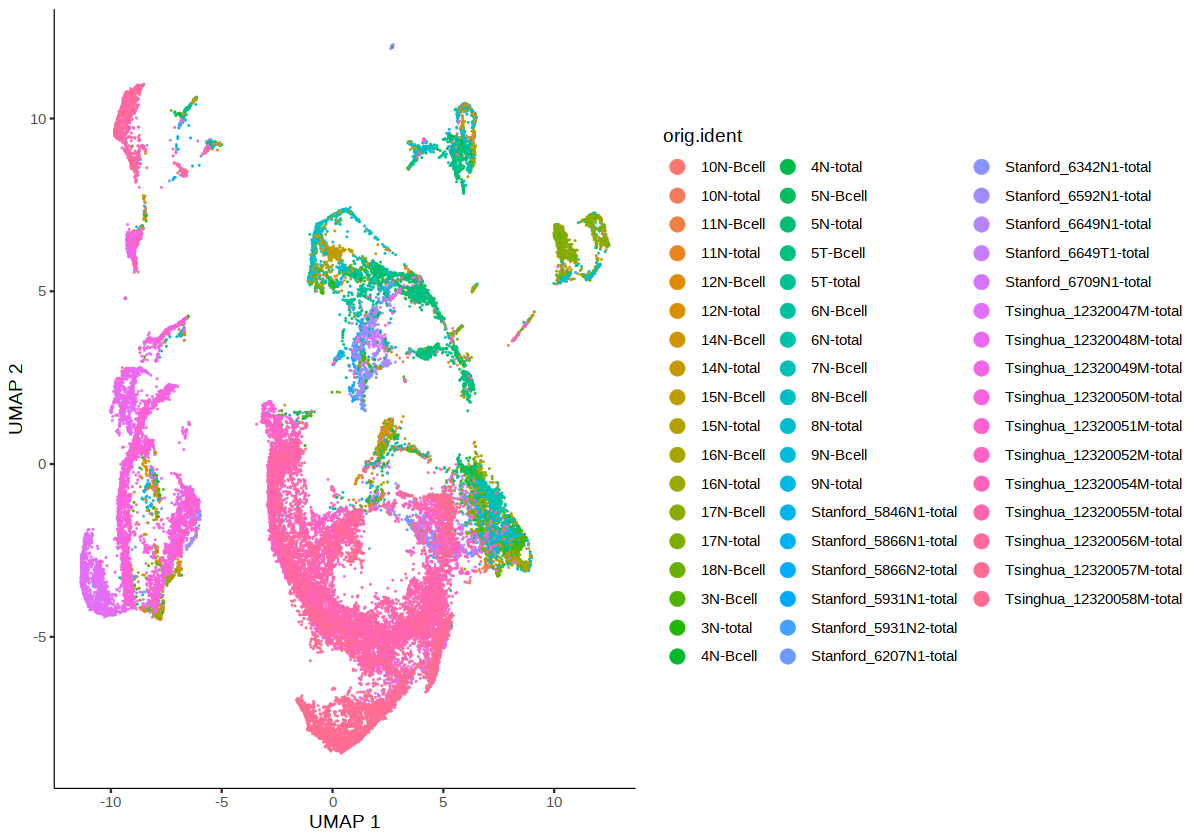

In [338]:
#cds_from_seurat <- reduce_dimension(cds_from_seurat)
options(repr.plot.width=10, repr.plot.height=7)
plot_cells(cds_from_seurat, cell_size = 0.3, show_trajectory_graph = FALSE, label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "orig.ident")+
theme(legend.position = "right")

In [339]:
# remove the batch effect
cds_from_seurat <- align_cds(cds_from_seurat, num_dim = 100,
                 alignment_group = "orig.ident")

Aligning cells from different batches using Batchelor. 
Please remember to cite:
	 Haghverdi L, Lun ATL, Morgan MD, Marioni JC (2018). 'Batch effects in single-cell RNA-sequencing data are corrected by matching mutual nearest neighbors.' Nat. Biotechnol., 36(5), 421-427. doi: 10.1038/nbt.4091



In [340]:
cds_from_seurat = reduce_dimension(cds_from_seurat,preprocess_method='Aligned')

In [341]:
metadata <- seurat@meta.data

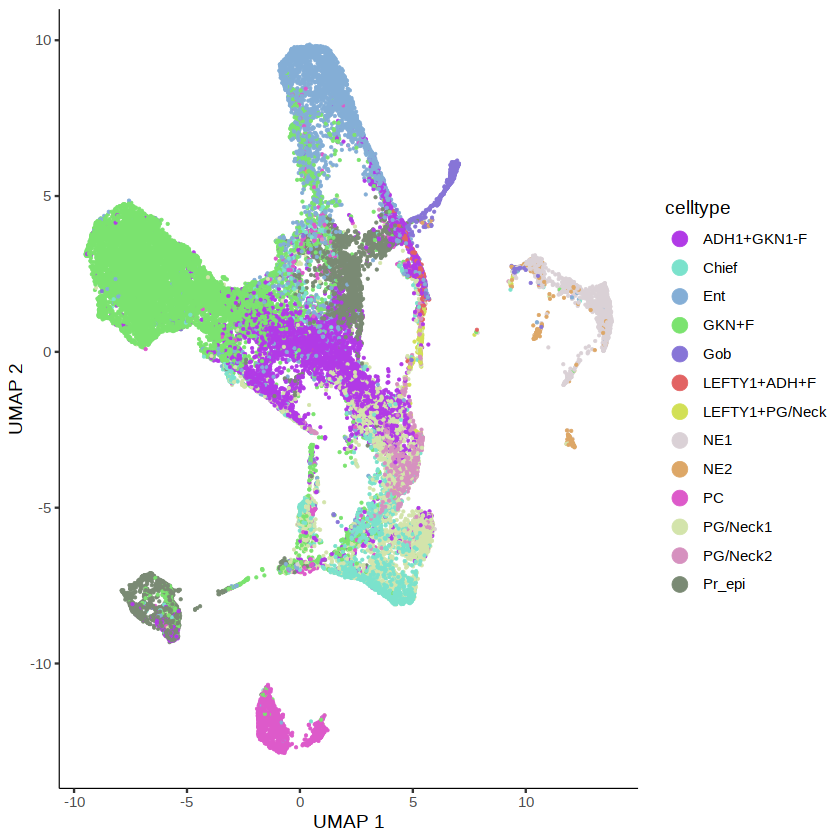

In [343]:
# confirm the batch effect reduction
#cds_from_seurat <- reduce_dimension(cds_from_seurat)
options(repr.plot.width=7, repr.plot.height=7)
plot_cells(cds_from_seurat, cell_size = 0.5, show_trajectory_graph = FALSE, label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "celltype")+
theme(legend.position = "right")+
scale_color_manual(values = unlist(colors[13]))

In [344]:
cds_from_seurat <- cluster_cells(cds_from_seurat, reduction_method = 'UMAP')
cds_from_seurat <- learn_graph(cds_from_seurat,use_partition = TRUE)

  |======================================================================| 100%
  |======================================================================| 100%


In [346]:
# This function can get the principal node from monocle3 pseudotime, 
# but I feel it is not accurate in my previous analysis.
# time_bin is cluster_name
# you can get earliest cellid from each cluster
get_earliest_principal_node <- function(cds, time_bin="LEFTY1+PG/Neck"){ 
  cell_ids <- which(colData(cds)[, "celltype"] == time_bin)
  
  closest_vertex <-
  cds@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(cds), ])
  root_pr_nodes <-
  igraph::V(principal_graph(cds)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}

In [347]:
metadata %>% filter(subcluster=='LEFTY1+PG/Neck') %>% rownames -> high_score_cells

In [349]:
seurat@meta.data %>% filter(subcluster=='LEFTY1+PG/Neck') %>% select(CytoTRACE) %>% arrange(desc(CytoTRACE)) %>% head

,CytoTRACE
,<dbl>
17N-Bcell_TAAGAGACACTCAGGC,0.9581673
Tsinghua_12320048M-total_CCAGCGAAGAGGGATA,0.9193227
Tsinghua_12320048M-total_CAAGATCAGCATGGCA,0.9173307
Tsinghua_12320048M-total_TCATTTGAGCCACGCT,0.9133466
Tsinghua_12320048M-total_CAACTAGTCACGACTA,0.9113546
Tsinghua_12320048M-total_TCACAAGAGATATACG,0.9113546


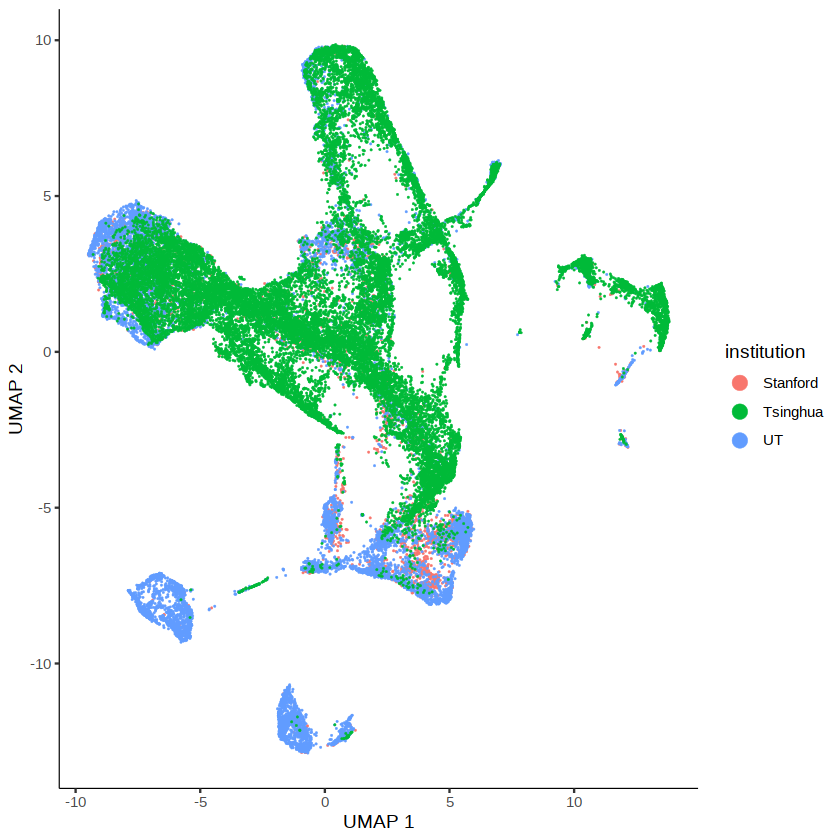

In [350]:
plot_cells(cds_from_seurat, cell_size = 0.3, show_trajectory_graph = FALSE, 
           label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "institution")

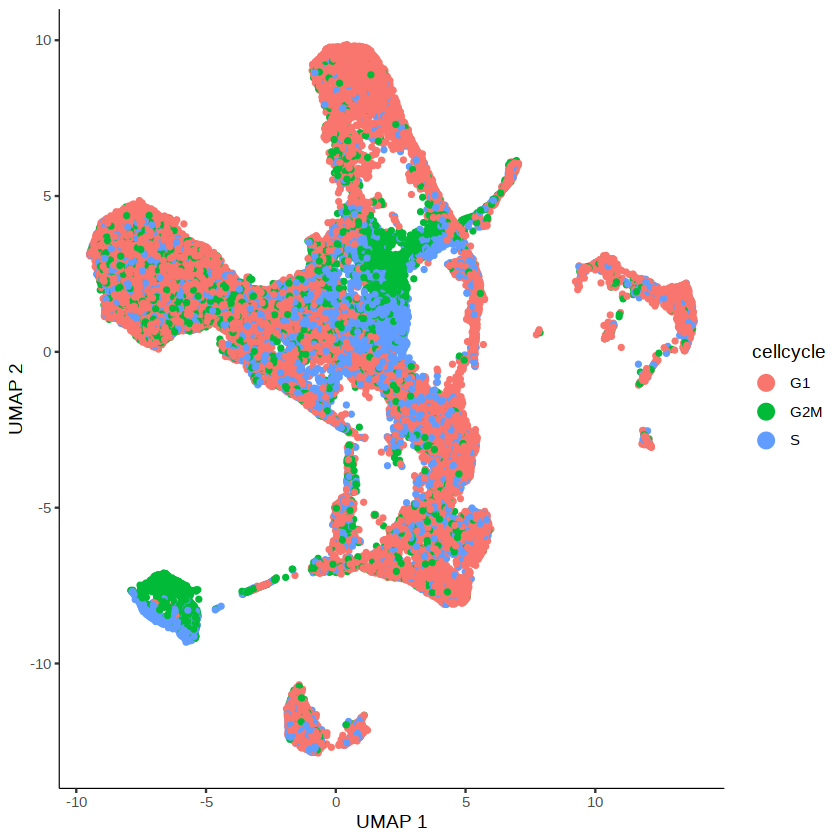

In [351]:
plot_cells(cds_from_seurat, cell_size = 1, show_trajectory_graph = FALSE, 
           label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "cellcycle")

# high_score_cells 1で上のクラスター、500で下のクラスター

In [353]:
metadata <- seurat@meta.data

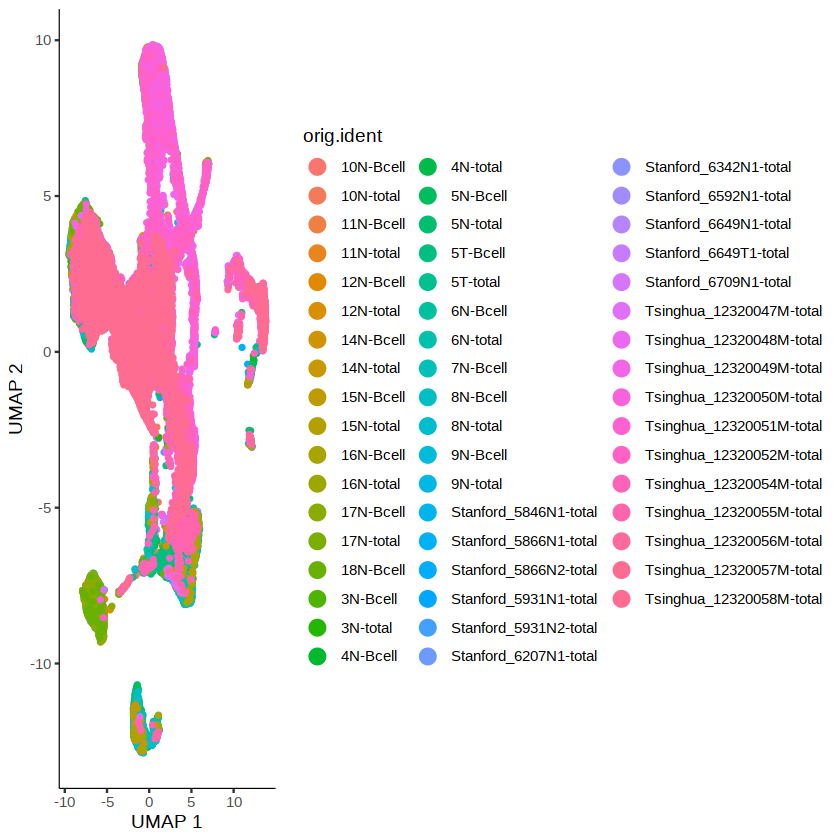

In [355]:
plot_cells(cds_from_seurat, cell_size = 1, show_trajectory_graph = FALSE, 
           label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "orig.ident")

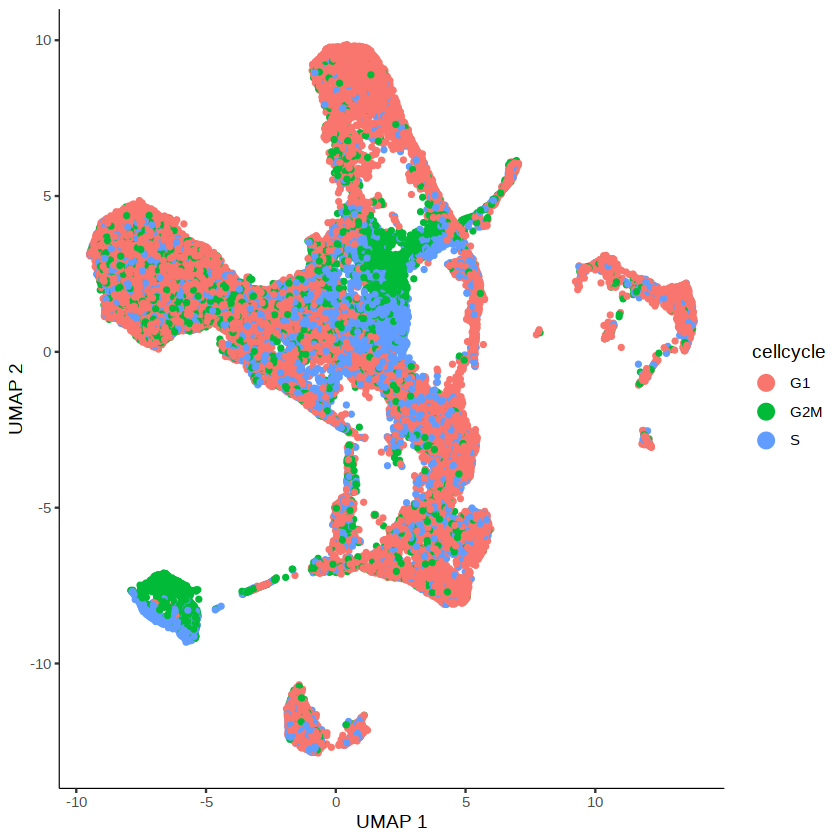

In [356]:
plot_cells(cds_from_seurat, cell_size = 1, show_trajectory_graph = FALSE, 
           label_cell_groups=FALSE, label_groups_by_cluster=FALSE,color_cells_by = "cellcycle")

### determine the root cell manually

In [357]:
cds_from_seurat <- order_cells(cds_from_seurat, root_cells='Tsinghua_12320048M-total_CCAGCGAAGAGGGATA')

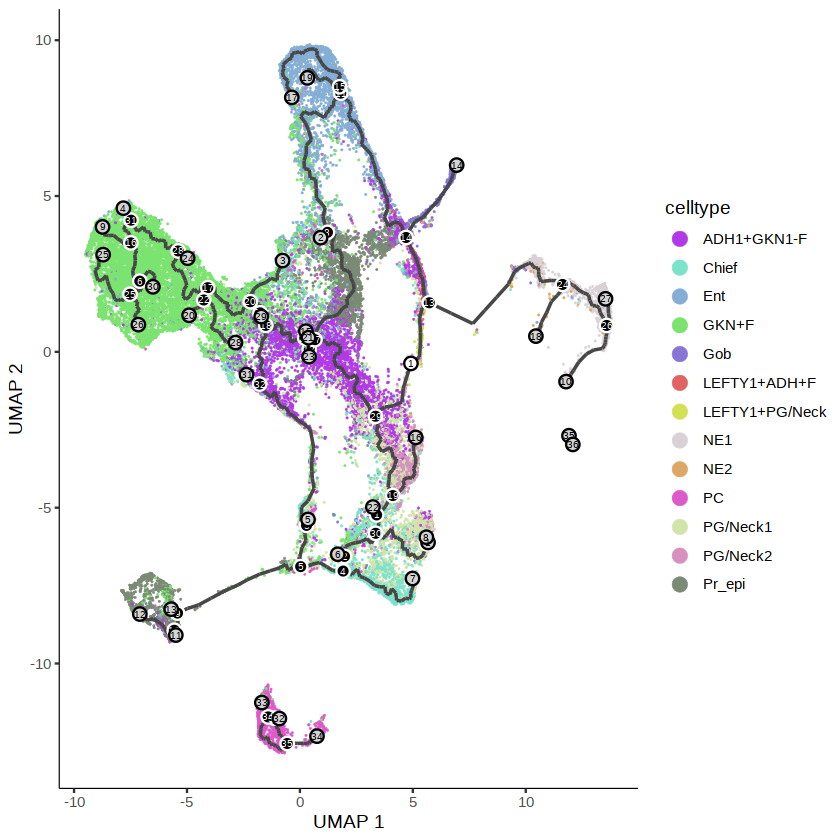

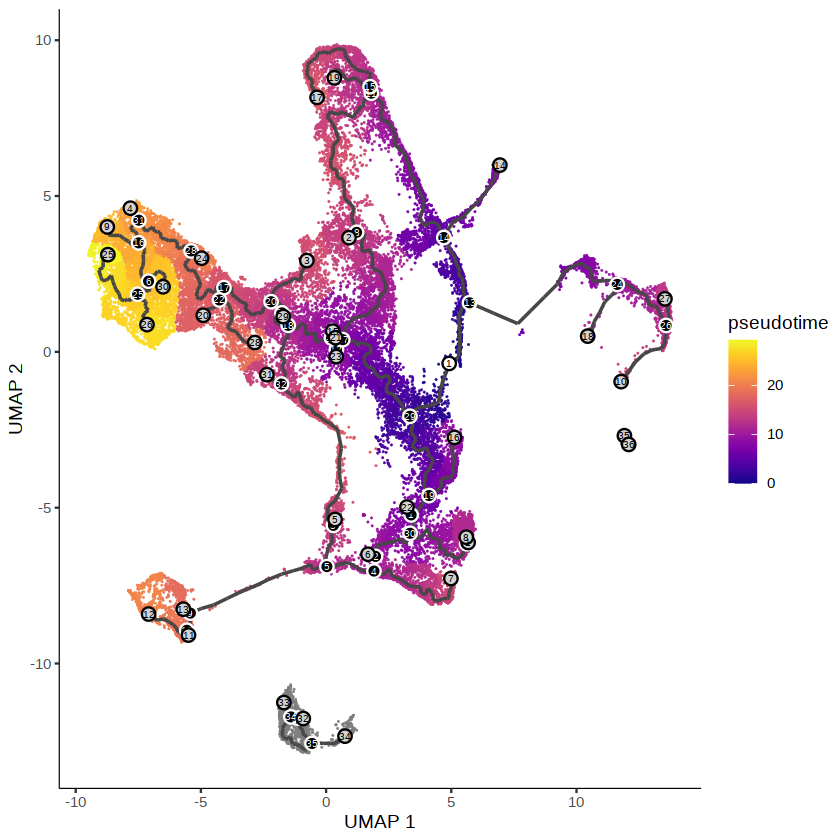

In [358]:
#cds <- preprocess_cds(cds, num_dim = 30)
#cds <- align_cds(cds, num_dim = 100, alignment_group = "orig.ident")
#cds <- align_cds(cds, num_dim = 30, alignment_group = "institution")
options(repr.plot.width=7, repr.plot.height=7)

plot_cells(cds_from_seurat, cell_size = 0.3, color_cells_by="celltype", label_cell_groups=FALSE)+
scale_color_manual(values = unlist(colors[13]))

if(1==0){
plot_cells(cds_from_seurat,
           color_cells_by = "cell.type",
        label_groups_by_cluster=FALSE,  
           cell_size = 1,
           group_label_size=5,
           label_leaves=TRUE,
           label_branch_points=TRUE)
}
    
#ggsave("/home/tsubosaka/integrated_data/fig/monocle_ENT_batch.pdf", width=12, height=7)

if (1==0){
plot_cells(cds_from_seurat,label_cell_groups = FALSE,
           color_cells_by = "cell.type",
        label_groups_by_cluster=FALSE,   
           cell_size = 1,
           group_label_size=5,
           label_leaves=TRUE,
           label_branch_points=TRUE)
}
plot_cells(cds_from_seurat,label_cell_groups = FALSE,
           color_cells_by = "pseudotime",
        label_groups_by_cluster=FALSE,   
           cell_size = 0.3,
           group_label_size=5,
           label_leaves=TRUE,
           label_branch_points=TRUE)
#ggsave("/home/tsubosaka/integrated_data/fig/monocle_ENT2_batch.pdf", width=12, height=7)

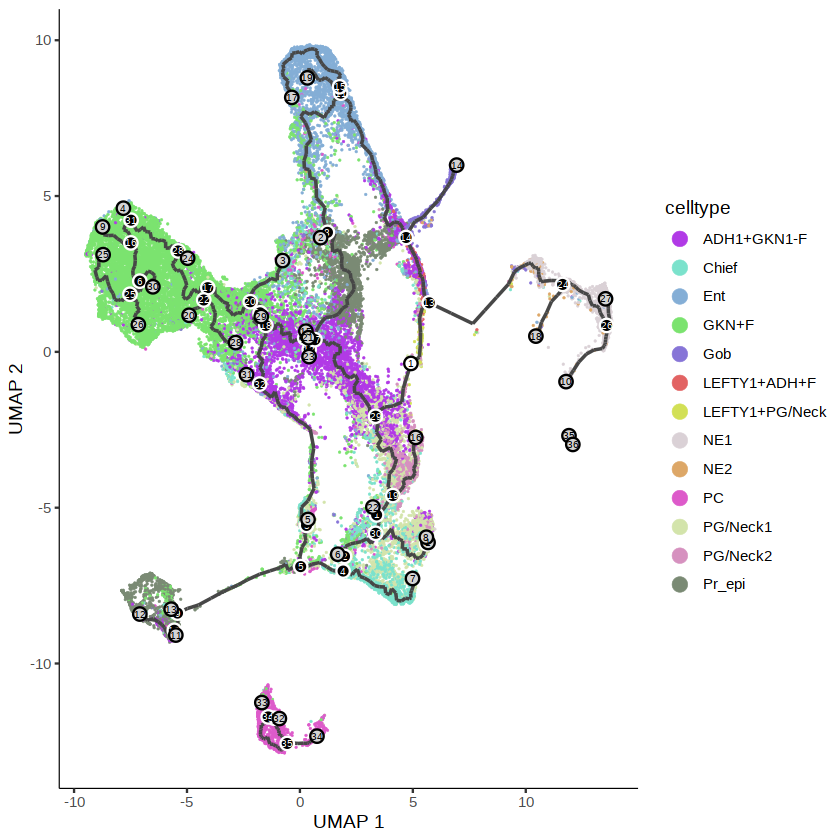

In [361]:
options(repr.plot.width=7, repr.plot.height=7)
plot_cells(cds_from_seurat, color_cells_by="celltype",label_cell_groups=FALSE)+
scale_color_manual(values = unlist(colors[13]))

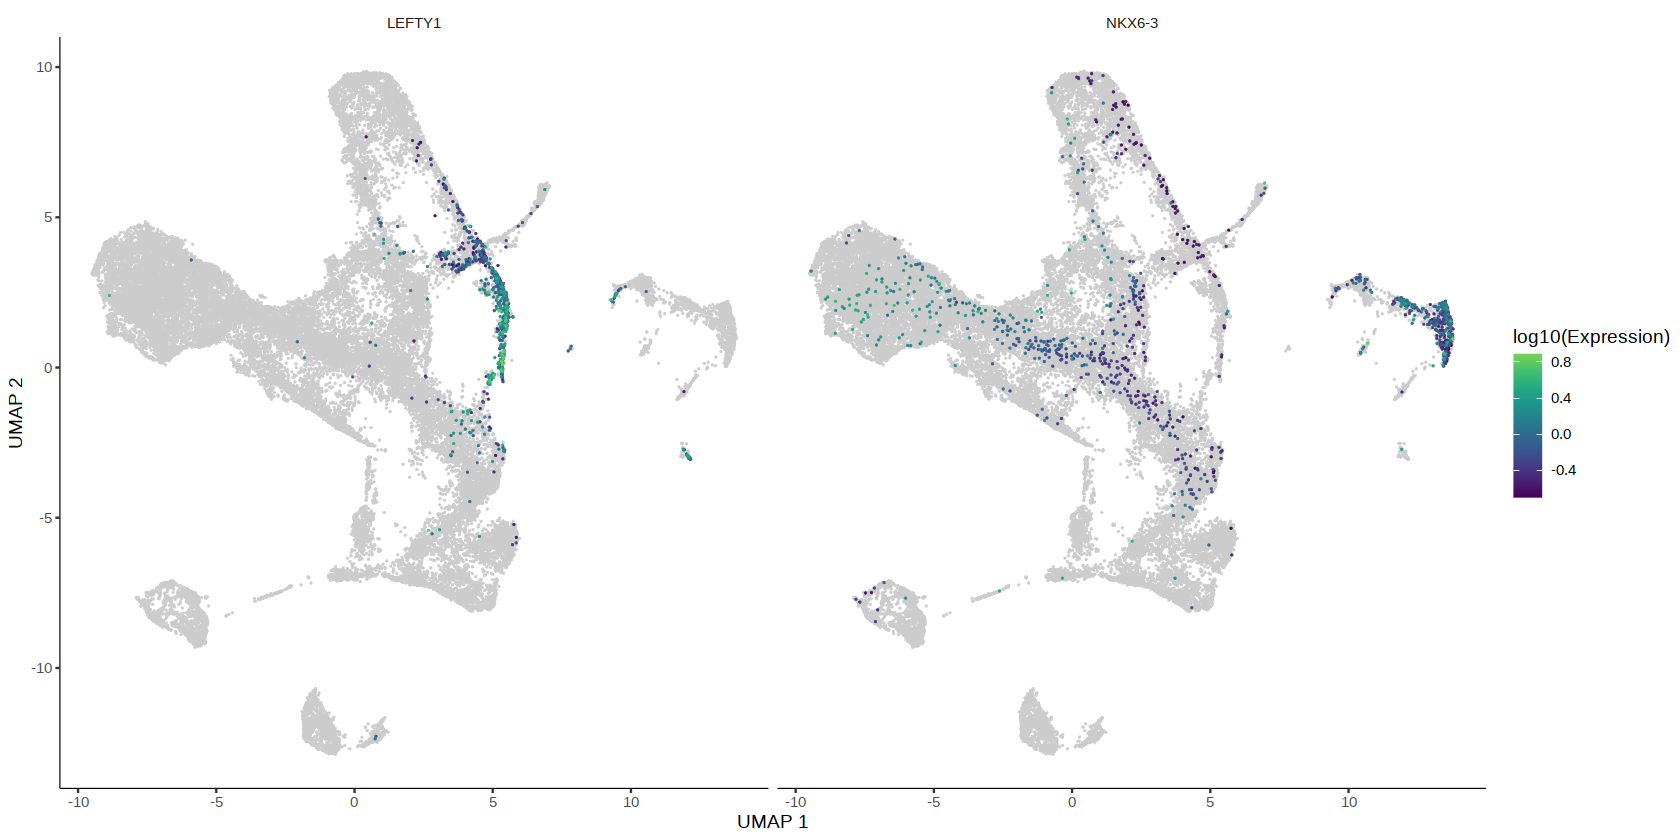

In [362]:
options(repr.plot.width=14, repr.plot.height=7)
plot_cells(cds_from_seurat, genes=c('LEFTY1','NKX6-3'), 
           show_trajectory_graph=FALSE, 
           label_cell_groups=FALSE)

In [586]:
intestinal_markers <- c('CDX2','OLFM4','CDH17',
                        'VIL1','MUC13','REG4',
                        'MUC2','TFF3','LYZ')
gasrtic_markers <- c('GIF','PGC','MUC1',
                    'MUC5AC','MUC6','TFF2',
                     'GAST','CLDN18','SHH',
                     'ATP4A','SOX2','LGR5'
                    )

In [592]:
stem <- c('LGR5','LEFTY1','SMOC2','ASCL2','TNFRSF19','AQP1')

In [595]:
stem2 <- c('BMI1','HOPX','LRIG1','TERT')

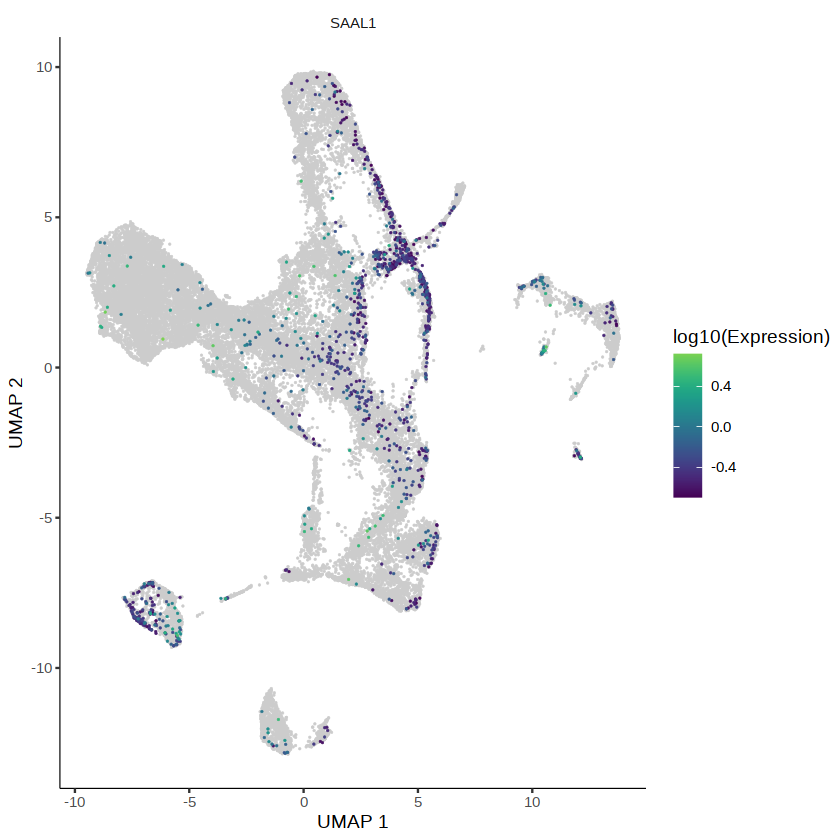

In [636]:
options(repr.plot.width=7, repr.plot.height=7)
plot_cells(cds_from_seurat, genes='SAAL1', 
           show_trajectory_graph=FALSE, 
           label_cell_groups=FALSE)

In [1174]:
lefty1_ADH_label <- colnames(subset(subset(seurat,idents='ADH1+GKN1-F'),LEFTY1>0))

In [1175]:
lefty1_PG_label <- colnames(subset(subset(seurat,idents='PG/Neck2'),LEFTY1>0))

In [1176]:
seurat@meta.data$'subcluster' <- as.character(seurat@meta.data$'subcluster')

In [1177]:
seurat@meta.data['subcluster'][lefty1_PG_label,] <- "LEFTY1+PG/Neck"

In [1178]:
seurat@meta.data['subcluster'][lefty1_ADH_label,] <- "LEFTY1+ADH+F"

### pseudotime expression plot

In [678]:
wnt_genes_ligand <- c('WNT10B','WNT2B','WNT5A','WNT3A','WNT4',
              'WNT7A','WNT7B','WNT9A','WNT9B')

In [679]:
my_genes <- rownames(subset(fData(cds_from_seurat),
gene_short_name %in% wnt_genes_ligand))


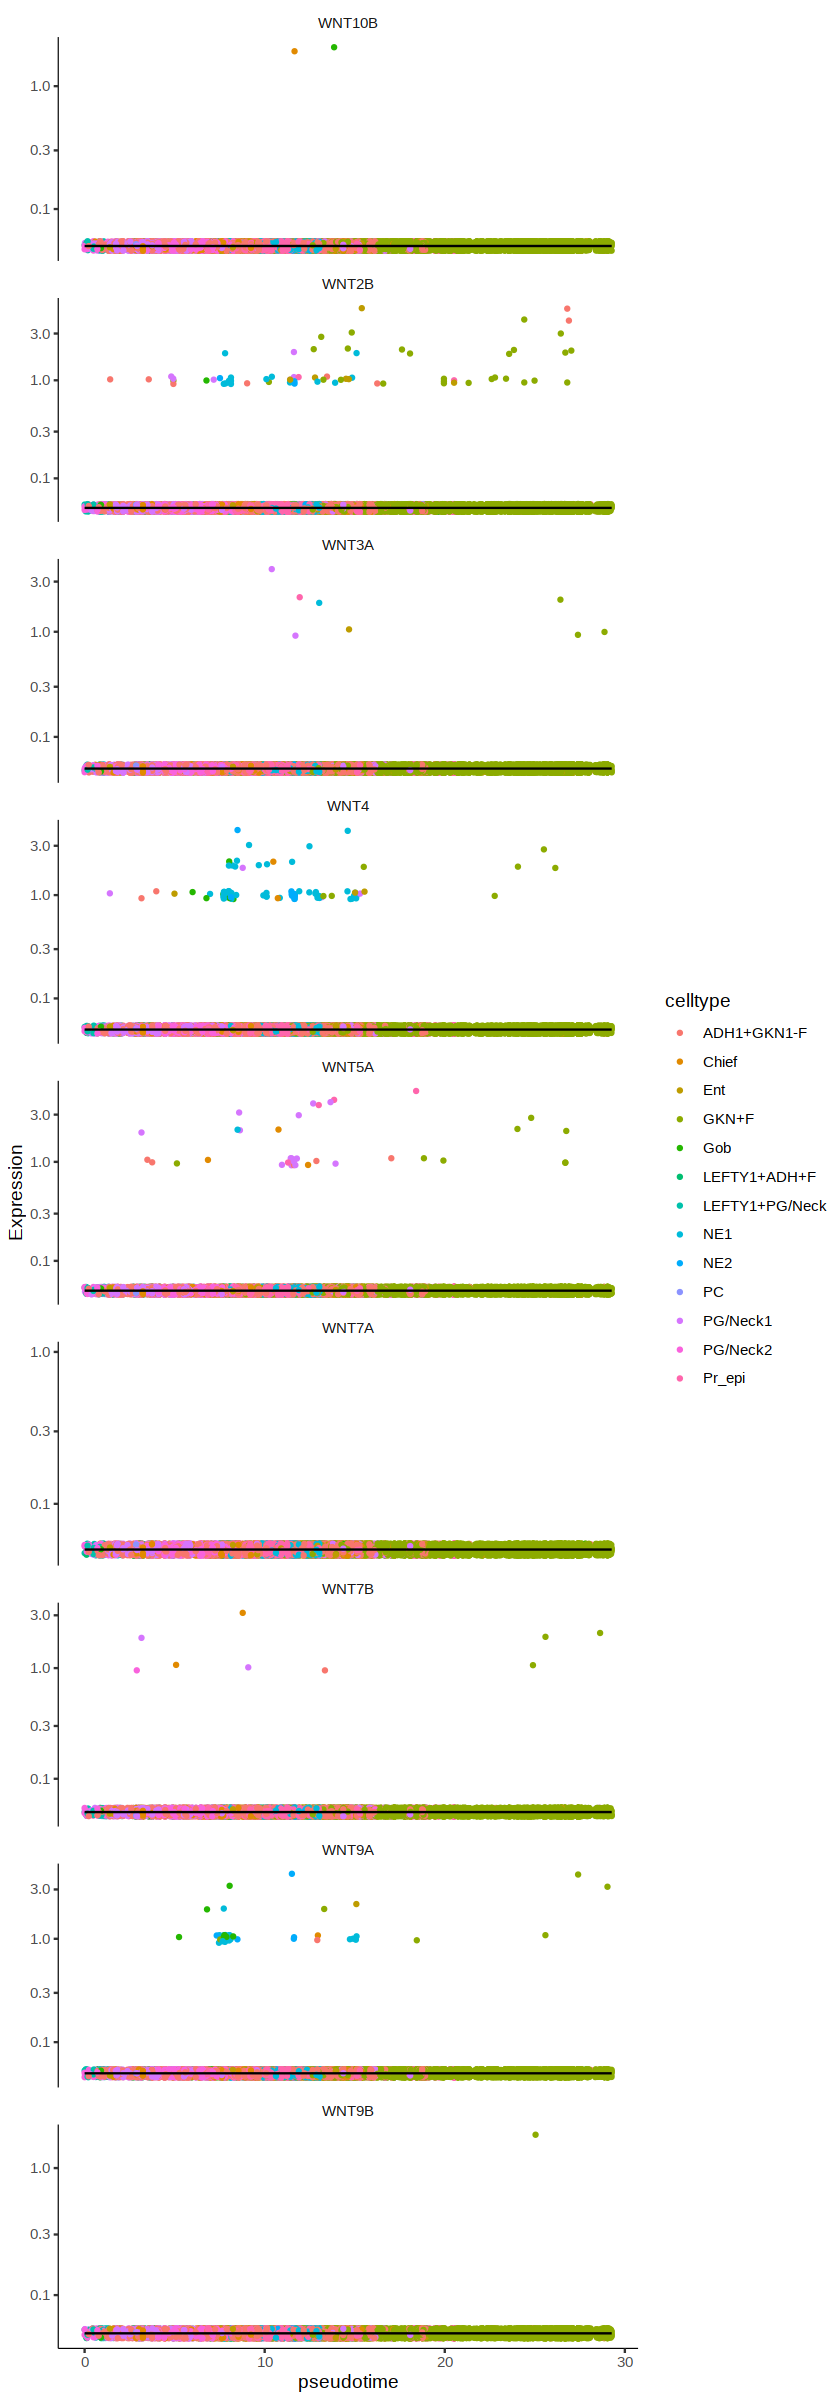

In [894]:
options(repr.plot.width=7, repr.plot.height=20)
plot_genes_in_pseudotime(cds_from_seurat[my_genes,],
color_cells_by="celltype",
                         min_expr=0.05)

### replace the UMAP coordinates of monocle3 with Seurat

In [288]:
colnames(monocle3) <- c('umap_1', 'umap_2')
monocle3 <- as.matrix(monocle3)
rownames(spatial) <- rownames(cosmx[[]])

cosmx[["tsne"]] <- CreateDimReducObject(embeddings = spatial)

Warning message:
“No assay specified, setting assay as RNA by default.”
